    Jupyter notebook for practicing with graph data science.

    Much of the code here is patterned after chapter 2 in
        Graph Data Science with Neo4j
        Estelle Scifo, Packt Publishing Ltd, 2023

    Michael A. Goodrich
    Brigham Young University

    March 2023

---


Requires
* os
* matplotlib
* seaborn
* pandas
* ipykernel ???

---

We'll begin by reading in a data set from a csv file into a pandas dataframe. We'll then inspect the first few rows of the dataframe to get a feel for the data.

In [15]:
""" Get data example from Kaggle 

    https://www.kaggle.com/datasets/rajugc/imdb-top-250-movies-dataset

    Copy code from the following to read in data:

    https://www.kaggle.com/code/rajugc/imdb-top-250-movies-eda

    The code is released under the Apache 2.0 open source license.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('databases/IMDB Top 250 Movies.csv') # prefix this file name with the directory in which you stored it
df.head()   # This function returns the first n rows for the object based on position. 
            # It is useful for quickly testing if your object has the right type of data in it.
            # https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html

,rank,name,year,rating,genre,certificate,run_time,tagline,budget,box_office,casts,directors,writers
0,1,The Shawshank Redemption,1994,9.3,Drama,R,2h 22m,Fear can hold you prisoner. Hope can set you f...,25000000,28884504,"Tim Robbins,Morgan Freeman,Bob Gunton,William ...",Frank Darabont,"Stephen King,Frank Darabont"
1,2,The Godfather,1972,9.2,"Crime,Drama",R,2h 55m,An offer you can't refuse.,6000000,250341816,"Marlon Brando,Al Pacino,James Caan,Diane Keato...",Francis Ford Coppola,"Mario Puzo,Francis Ford Coppola"
2,3,The Dark Knight,2008,9.0,"Action,Crime,Drama",PG-13,2h 32m,Why So Serious?,185000000,1006234167,"Christian Bale,Heath Ledger,Aaron Eckhart,Mich...",Christopher Nolan,"Jonathan Nolan,Christopher Nolan,David S. Goyer"
3,4,The Godfather Part II,1974,9.0,"Crime,Drama",R,3h 22m,All the power on earth can't change destiny.,13000000,47961919,"Al Pacino,Robert De Niro,Robert Duvall,Diane K...",Francis Ford Coppola,"Francis Ford Coppola,Mario Puzo"
4,5,12 Angry Men,1957,9.0,"Crime,Drama",Approved,1h 36m,Life Is In Their Hands -- Death Is On Their Mi...,350000,955,"Henry Fonda,Lee J. Cobb,Martin Balsam,John Fie...",Sidney Lumet,Reginald Rose


_Show the information about what is contained in each column_

In [16]:
df.info()
# This method prints information about a DataFrame including the index dtype and 
# columns, non-null values and memory usage.
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rank         250 non-null    int64  
 1   name         250 non-null    object 
 2   year         250 non-null    int64  
 3   rating       250 non-null    float64
 4   genre        250 non-null    object 
 5   certificate  250 non-null    object 
 6   run_time     250 non-null    object 
 7   tagline      250 non-null    object 
 8   budget       250 non-null    object 
 9   box_office   250 non-null    object 
 10  casts        250 non-null    object 
 11  directors    250 non-null    object 
 12  writers      250 non-null    object 
dtypes: float64(1), int64(2), object(10)
memory usage: 25.5+ KB


_Gather some summary information about which genres are present in the data_

In [17]:
df.value_counts('genre')

genre
Drama                         19
Crime,Drama                   14
Animation,Adventure,Comedy    10
Biography,Drama,History        9
Crime,Drama,Mystery            9
                              ..
Crime,Mystery,Thriller         1
Crime,Sci-Fi                   1
Adventure,Comedy,Sci-Fi        1
Adventure,Comedy,Fantasy       1
Adventure,Comedy,Drama         1
Length: 104, dtype: int64

***

Our next task is to define a schema for the graph we want to create.

The schema should be set up in a way that allows us to answer questions that we might ask.

![Graph schema](GraphSchema.drawio.svg)

See Neo4j book, page 31

---

We now need to go through the database and create a node for each movie, genre, movie certificate, and person. There are graph database query tools for doing this (e.g., Cypher in Neo4j), but I'm trying to teach this without requiring you to learn a lot of new tools, so I'll try to write code that extracts movie information into _nodes_. Each node will have metadata, describing what the node represents. We'll then create _edges_ using the "resource description framework" (RDF), which represents relationships between nodes using a _subject predicate object_ relationship template.

In [18]:
""" Graph manager tools 

    For use with GraphDataScience_Practice.ipynb

    Michael A. Goodrich
    Brigham Young University

    March 2023
"""
import networkx as nx
import matplotlib as mpl
from matplotlib import pyplot as plt

class GraphManager:
    def __init__(self,is_directed = False):
        if is_directed:
            self.G = nx.empty_graph(create_using=nx.DiGraph)
        else:
            self.G = nx.empty_graph()
    def addNodes(self,node_set):
        self.G.add_nodes_from(node_set)
    def addEdges(self,edge_set):
        self.G.add_edges_from(edge_set)
    def showPlot(self,with_labels = False):
        plt.figure(1); plt.clf(); plt.ion()
        pos = nx.nx_agraph.graphviz_layout(self.G,prog='neato')
        if with_labels:
            nx.draw(self.G,pos,node_color = 'y', alpha = 0.8, node_size = 700, with_labels = True)
        else:
            nx.draw(self.G,pos,node_color = 'y', alpha = 0.8, node_size = 100)
        plt.show()
    def getGraph(self): return self.G

In [19]:
""" Functions for pulling out unique genres
    Many movies are categorized under multiple genres
"""
#from GraphManager import *

def get_unique_genres(df):
    genres = df["genre"]
    set_of_genres = set()
    for i in range(len(genres)):
        movie_genre_types = genres[i].split(',')
        for genre in movie_genre_types:
            set_of_genres.add(genre)
    #print(set_of_genres)
    return set_of_genres

def get_movies(df):
    # Identify the movies by their ranking from the database rather than from the title"
    movie_rankings = df["rank"]
    set_of_rankings = set()
    for i in range(len(movie_rankings)):
        set_of_rankings.add(str(movie_rankings[i]))
    print("There are ",len(set_of_rankings),"movies in the database")
    return set_of_rankings

def get_movie_genre_edges(df):
    rankings = df["rank"]
    genres = df["genre"]
    set_of_edges = set()
    for i in range(len(rankings)):
        movie_genre_types = genres[i].split(',')
        for genre in movie_genre_types:
            set_of_edges.add((str(rankings[i]),genre))
    return set_of_edges

    


There are  250 movies in the database


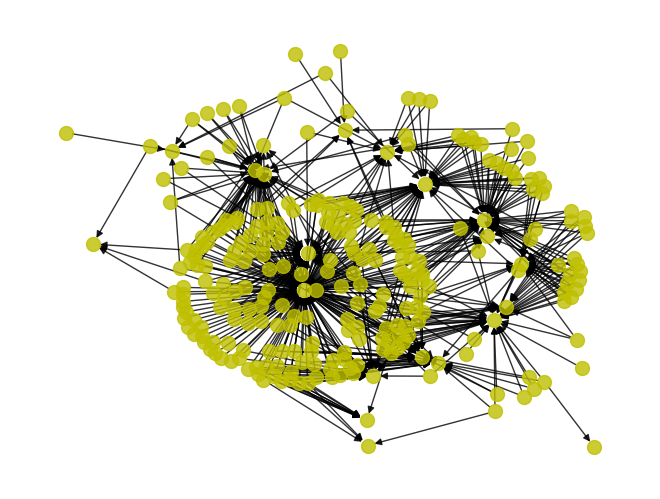

In [20]:

genres = get_unique_genres(df)
myGraphManager = GraphManager(is_directed=True)
myGraphManager.addNodes(genres)
movies = get_movies(df)
myGraphManager.addNodes(movies)
edge_set = get_movie_genre_edges(df)
myGraphManager.addEdges(edge_set)
myGraphManager.showPlot()


In [ ]:
""" Creating graph projections to help garner information from the graph.
    See page 70 of Neo4j book    
"""

# For each genre
    # Find all neighboring movies that point to it
    # Create an edge between those movies
projectionGraphManager = GraphManager()
myGraphManager.addNodes(movies)
edge_set = get_movie_genre_edges(df)
G = myGraphManager()
for node in G.nodes:
    if node not in 
